# DCGAN_for_MNIST

In [ ]:
import numpy as np

from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D
from tensorflow.keras.layers import Conv2DTranspose, LeakyReLU, Dropout
from tensorflow.keras.utils.vis_utils import plot_model

import matplotlib.pyplot as plt

In [ ]:
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0

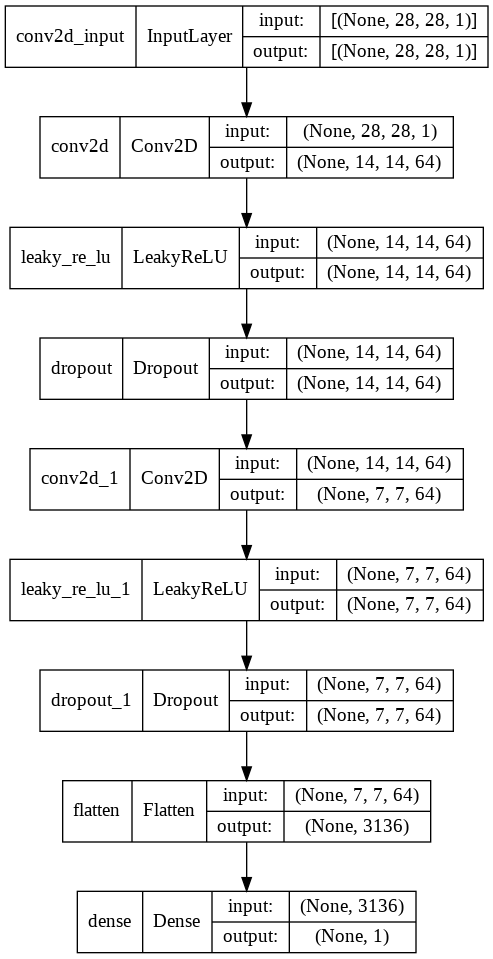

In [ ]:
discriminator_model = define_discriminator()
discriminator_model.summary()
plot_model(discriminator_model, to_file = 'discriminator_model.png', show_shapes = True, show_layer_names = True)

In [ ]:
def define_generator(latent_dim):
	model = Sequential()
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      262272    
 ranspose)                                              

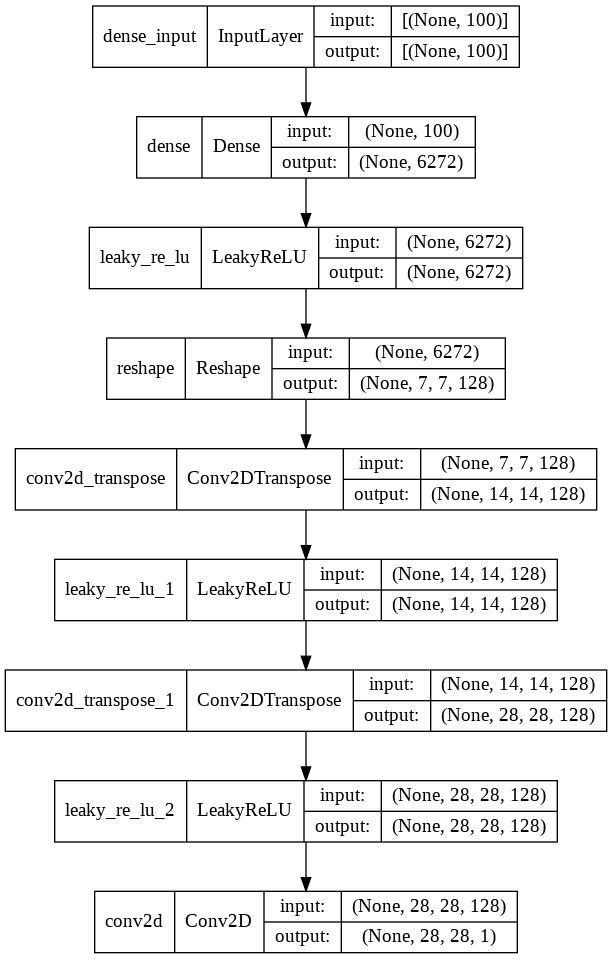

In [ ]:
latent_dim = 100
generator_model = define_generator(latent_dim)
generator_model.summary()
plot_model(generator_model, to_file = 'generator_model.png', show_shapes = True, show_layer_names = True)

In [ ]:
def define_gan(generator, discriminator):
	discriminator.trainable = False
	model = Sequential()
	model.add(generator)
	model.add(discriminator)
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 28, 28, 1)         568449    
                                                                 
 sequential (Sequential)     (None, 1)                 40705     
                                                                 
Total params: 609,154
Trainable params: 568,449
Non-trainable params: 40,705
_________________________________________________________________


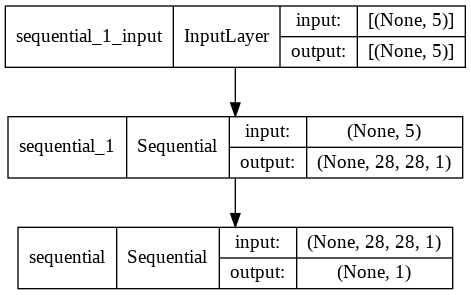

In [ ]:
gan_model = define_gan(generator_model, discriminator_model)
gan_model.summary()
plot_model(gan_model, to_file = 'gan_model.png', show_layer_names = True, show_shapes = True)

In [ ]:
def load_real_samples():
	(trainX, _), (_, _) = load_data()
	X = np.expand_dims(trainX, axis=-1)
	X = X.astype('float32')
	X = X / 255.0
	return X

In [ ]:
def generate_real_samples(dataset, n_samples):
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	y = np.ones((n_samples, 1))
	return X, y

In [ ]:
def generate_latent_points(latent_dim, n_samples):
	x_input = np.random.randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

def generate_fake_samples(g_model, latent_dim, n_samples):
	x_input = generate_latent_points(latent_dim, n_samples)
	X = g_model.predict(x_input)
	y = np.zeros((n_samples, 1))
	return X, y

In [ ]:
def save_plot(examples, epoch, n=10):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	plt.savefig(filename)
	plt.show()
 
def summarize_performance(epoch, generator, discriminator, dataset, latent_dim, n_samples=100):
  X_real, y_real = generate_real_samples(dataset, n_samples)
  _, acc_real = discriminator.evaluate(X_real, y_real, verbose=0)
  x_fake, y_fake = generate_fake_samples(generator, latent_dim, n_samples)
  _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
  print('Epoch: ' + str(epoch) + ' Real Acc.: ' + str(acc_real*100) + ' Fake Acc.: '+ str(acc_fake*100))
  save_plot(x_fake, epoch)
  filename = 'generator_model_%03d.h5' % (epoch + 1)
  generator.save(filename)

In [ ]:
def train_gan(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  for i in range(n_epochs):
    for j in range(bat_per_epo):
      X_real, y_real = generate_real_samples(dataset, half_batch)
      X_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)
      X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
      d_loss, _ = discriminator.train_on_batch(X, y)
      X_gan = generate_latent_points(latent_dim, n_batch)
      y_gan = np.ones((n_batch, 1))
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      if (j+1)/bat_per_epo in (1/234, 1/2, 1):
        print('Epoch %d: batch %d/%d, d_loss=%.3f, g_loss=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
    if (i+1) % 10 == 0:
      summarize_performance(i, generator, discriminator, dataset, latent_dim)

In [ ]:
latent_dim = 100

In [ ]:
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)

In [ ]:
dataset = load_real_samples()

11501568/11490434 [==============================] - 0s 0us/step


Epoch 1: batch 1/234, d_loss=0.686, g_loss=0.726
Epoch 1: batch 117/234, d_loss=0.368, g_loss=1.162
Epoch 1: batch 234/234, d_loss=0.625, g_loss=0.795
Epoch 2: batch 1/234, d_loss=0.639, g_loss=0.765
Epoch 2: batch 117/234, d_loss=0.686, g_loss=0.756
Epoch 2: batch 234/234, d_loss=0.674, g_loss=0.749
Epoch 3: batch 1/234, d_loss=0.662, g_loss=0.766
Epoch 3: batch 117/234, d_loss=0.734, g_loss=0.672
Epoch 3: batch 234/234, d_loss=0.830, g_loss=0.591
Epoch 4: batch 1/234, d_loss=0.832, g_loss=0.601
Epoch 4: batch 117/234, d_loss=0.595, g_loss=0.718
Epoch 4: batch 234/234, d_loss=0.700, g_loss=0.709
Epoch 5: batch 1/234, d_loss=0.692, g_loss=0.705
Epoch 5: batch 117/234, d_loss=0.700, g_loss=0.704
Epoch 5: batch 234/234, d_loss=0.686, g_loss=0.716
Epoch 6: batch 1/234, d_loss=0.681, g_loss=0.717
Epoch 6: batch 117/234, d_loss=0.691, g_loss=0.711
Epoch 6: batch 234/234, d_loss=0.691, g_loss=0.697
Epoch 7: batch 1/234, d_loss=0.698, g_loss=0.705
Epoch 7: batch 117/234, d_loss=0.685, g_loss=

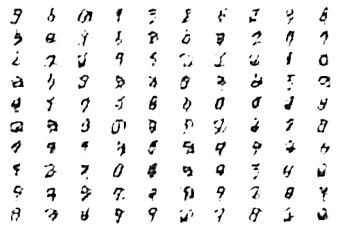

Epoch 11: batch 1/234, d_loss=0.693, g_loss=0.714
Epoch 11: batch 117/234, d_loss=0.679, g_loss=0.705
Epoch 11: batch 234/234, d_loss=0.682, g_loss=0.716
Epoch 12: batch 1/234, d_loss=0.678, g_loss=0.745
Epoch 12: batch 117/234, d_loss=0.696, g_loss=0.681
Epoch 12: batch 234/234, d_loss=0.687, g_loss=0.718
Epoch 13: batch 1/234, d_loss=0.688, g_loss=0.706
Epoch 13: batch 117/234, d_loss=0.680, g_loss=0.701
Epoch 13: batch 234/234, d_loss=0.699, g_loss=0.722
Epoch 14: batch 1/234, d_loss=0.689, g_loss=0.714
Epoch 14: batch 117/234, d_loss=0.682, g_loss=0.723
Epoch 14: batch 234/234, d_loss=0.682, g_loss=0.736
Epoch 15: batch 1/234, d_loss=0.685, g_loss=0.747
Epoch 15: batch 117/234, d_loss=0.687, g_loss=0.725
Epoch 15: batch 234/234, d_loss=0.684, g_loss=0.679
Epoch 16: batch 1/234, d_loss=0.686, g_loss=0.695
Epoch 16: batch 117/234, d_loss=0.681, g_loss=0.667
Epoch 16: batch 234/234, d_loss=0.687, g_loss=0.756
Epoch 17: batch 1/234, d_loss=0.690, g_loss=0.715
Epoch 17: batch 117/234, d

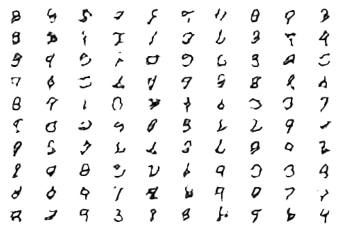

Epoch 21: batch 1/234, d_loss=0.686, g_loss=0.662
Epoch 21: batch 117/234, d_loss=0.690, g_loss=0.690
Epoch 21: batch 234/234, d_loss=0.688, g_loss=0.661
Epoch 22: batch 1/234, d_loss=0.685, g_loss=0.649
Epoch 22: batch 117/234, d_loss=0.683, g_loss=0.685
Epoch 22: batch 234/234, d_loss=0.684, g_loss=0.684
Epoch 23: batch 1/234, d_loss=0.689, g_loss=0.684
Epoch 23: batch 117/234, d_loss=0.687, g_loss=0.675
Epoch 23: batch 234/234, d_loss=0.681, g_loss=0.680
Epoch 24: batch 1/234, d_loss=0.681, g_loss=0.688
Epoch 24: batch 117/234, d_loss=0.690, g_loss=0.764
Epoch 24: batch 234/234, d_loss=0.690, g_loss=0.667
Epoch 25: batch 1/234, d_loss=0.691, g_loss=0.646
Epoch 25: batch 117/234, d_loss=0.691, g_loss=0.744
Epoch 25: batch 234/234, d_loss=0.684, g_loss=0.713
Epoch 26: batch 1/234, d_loss=0.694, g_loss=0.718
Epoch 26: batch 117/234, d_loss=0.691, g_loss=0.688
Epoch 26: batch 234/234, d_loss=0.677, g_loss=0.706
Epoch 27: batch 1/234, d_loss=0.689, g_loss=0.703
Epoch 27: batch 117/234, d

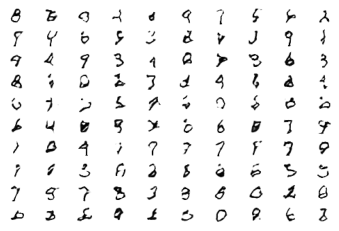

Epoch 31: batch 1/234, d_loss=0.682, g_loss=0.680
Epoch 31: batch 117/234, d_loss=0.692, g_loss=0.676
Epoch 31: batch 234/234, d_loss=0.687, g_loss=0.678
Epoch 32: batch 1/234, d_loss=0.694, g_loss=0.705
Epoch 32: batch 117/234, d_loss=0.695, g_loss=0.653
Epoch 32: batch 234/234, d_loss=0.696, g_loss=0.696
Epoch 33: batch 1/234, d_loss=0.692, g_loss=0.706
Epoch 33: batch 117/234, d_loss=0.688, g_loss=0.706
Epoch 33: batch 234/234, d_loss=0.686, g_loss=0.767
Epoch 34: batch 1/234, d_loss=0.677, g_loss=0.792
Epoch 34: batch 117/234, d_loss=0.684, g_loss=0.676
Epoch 34: batch 234/234, d_loss=0.690, g_loss=0.721
Epoch 35: batch 1/234, d_loss=0.688, g_loss=0.682
Epoch 35: batch 117/234, d_loss=0.691, g_loss=0.722
Epoch 35: batch 234/234, d_loss=0.691, g_loss=0.739
Epoch 36: batch 1/234, d_loss=0.684, g_loss=0.729
Epoch 36: batch 117/234, d_loss=0.690, g_loss=0.702
Epoch 36: batch 234/234, d_loss=0.689, g_loss=0.733
Epoch 37: batch 1/234, d_loss=0.686, g_loss=0.699
Epoch 37: batch 117/234, d

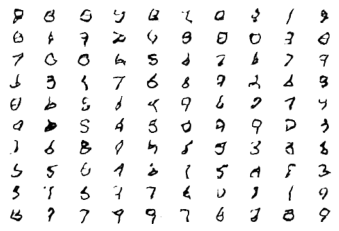

Epoch 41: batch 1/234, d_loss=0.694, g_loss=0.685
Epoch 41: batch 117/234, d_loss=0.699, g_loss=0.712
Epoch 41: batch 234/234, d_loss=0.690, g_loss=0.752
Epoch 42: batch 1/234, d_loss=0.691, g_loss=0.750
Epoch 42: batch 117/234, d_loss=0.687, g_loss=0.705
Epoch 42: batch 234/234, d_loss=0.691, g_loss=0.719
Epoch 43: batch 1/234, d_loss=0.695, g_loss=0.730
Epoch 43: batch 117/234, d_loss=0.686, g_loss=0.718
Epoch 43: batch 234/234, d_loss=0.688, g_loss=0.734
Epoch 44: batch 1/234, d_loss=0.698, g_loss=0.710
Epoch 44: batch 117/234, d_loss=0.689, g_loss=0.700
Epoch 44: batch 234/234, d_loss=0.695, g_loss=0.705
Epoch 45: batch 1/234, d_loss=0.699, g_loss=0.701
Epoch 45: batch 117/234, d_loss=0.692, g_loss=0.724
Epoch 45: batch 234/234, d_loss=0.680, g_loss=0.725
Epoch 46: batch 1/234, d_loss=0.684, g_loss=0.697
Epoch 46: batch 117/234, d_loss=0.689, g_loss=0.684
Epoch 46: batch 234/234, d_loss=0.689, g_loss=0.702
Epoch 47: batch 1/234, d_loss=0.698, g_loss=0.708
Epoch 47: batch 117/234, d

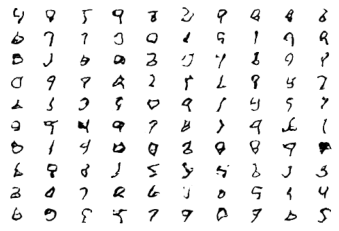

Epoch 51: batch 1/234, d_loss=0.690, g_loss=0.697
Epoch 51: batch 117/234, d_loss=0.695, g_loss=0.710
Epoch 51: batch 234/234, d_loss=0.683, g_loss=0.720
Epoch 52: batch 1/234, d_loss=0.691, g_loss=0.742
Epoch 52: batch 117/234, d_loss=0.688, g_loss=0.711
Epoch 52: batch 234/234, d_loss=0.692, g_loss=0.702
Epoch 53: batch 1/234, d_loss=0.691, g_loss=0.707
Epoch 53: batch 117/234, d_loss=0.689, g_loss=0.695
Epoch 53: batch 234/234, d_loss=0.699, g_loss=0.695
Epoch 54: batch 1/234, d_loss=0.687, g_loss=0.723
Epoch 54: batch 117/234, d_loss=0.687, g_loss=0.680
Epoch 54: batch 234/234, d_loss=0.697, g_loss=0.686
Epoch 55: batch 1/234, d_loss=0.688, g_loss=0.704
Epoch 55: batch 117/234, d_loss=0.685, g_loss=0.713
Epoch 55: batch 234/234, d_loss=0.691, g_loss=0.711
Epoch 56: batch 1/234, d_loss=0.686, g_loss=0.703
Epoch 56: batch 117/234, d_loss=0.684, g_loss=0.705
Epoch 56: batch 234/234, d_loss=0.693, g_loss=0.694
Epoch 57: batch 1/234, d_loss=0.693, g_loss=0.722
Epoch 57: batch 117/234, d

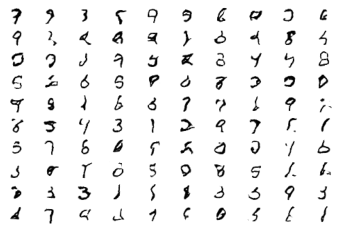

Epoch 61: batch 1/234, d_loss=0.686, g_loss=0.684
Epoch 61: batch 117/234, d_loss=0.688, g_loss=0.707
Epoch 61: batch 234/234, d_loss=0.689, g_loss=0.702
Epoch 62: batch 1/234, d_loss=0.691, g_loss=0.706
Epoch 62: batch 117/234, d_loss=0.692, g_loss=0.703
Epoch 62: batch 234/234, d_loss=0.681, g_loss=0.703
Epoch 63: batch 1/234, d_loss=0.693, g_loss=0.707
Epoch 63: batch 117/234, d_loss=0.683, g_loss=0.678
Epoch 63: batch 234/234, d_loss=0.689, g_loss=0.697
Epoch 64: batch 1/234, d_loss=0.693, g_loss=0.708
Epoch 64: batch 117/234, d_loss=0.687, g_loss=0.711
Epoch 64: batch 234/234, d_loss=0.692, g_loss=0.708
Epoch 65: batch 1/234, d_loss=0.695, g_loss=0.683
Epoch 65: batch 117/234, d_loss=0.693, g_loss=0.693
Epoch 65: batch 234/234, d_loss=0.686, g_loss=0.726
Epoch 66: batch 1/234, d_loss=0.695, g_loss=0.730
Epoch 66: batch 117/234, d_loss=0.699, g_loss=0.698
Epoch 66: batch 234/234, d_loss=0.691, g_loss=0.684
Epoch 67: batch 1/234, d_loss=0.691, g_loss=0.701
Epoch 67: batch 117/234, d

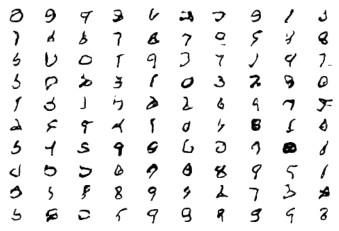

Epoch 71: batch 1/234, d_loss=0.690, g_loss=0.701
Epoch 71: batch 117/234, d_loss=0.684, g_loss=0.706
Epoch 71: batch 234/234, d_loss=0.703, g_loss=0.696
Epoch 72: batch 1/234, d_loss=0.696, g_loss=0.705
Epoch 72: batch 117/234, d_loss=0.690, g_loss=0.696
Epoch 72: batch 234/234, d_loss=0.689, g_loss=0.712
Epoch 73: batch 1/234, d_loss=0.690, g_loss=0.705
Epoch 73: batch 117/234, d_loss=0.689, g_loss=0.715
Epoch 73: batch 234/234, d_loss=0.693, g_loss=0.665
Epoch 74: batch 1/234, d_loss=0.681, g_loss=0.686
Epoch 74: batch 117/234, d_loss=0.688, g_loss=0.697
Epoch 74: batch 234/234, d_loss=0.691, g_loss=0.687
Epoch 75: batch 1/234, d_loss=0.690, g_loss=0.698
Epoch 75: batch 117/234, d_loss=0.694, g_loss=0.711
Epoch 75: batch 234/234, d_loss=0.688, g_loss=0.704
Epoch 76: batch 1/234, d_loss=0.685, g_loss=0.691
Epoch 76: batch 117/234, d_loss=0.696, g_loss=0.709
Epoch 76: batch 234/234, d_loss=0.692, g_loss=0.694
Epoch 77: batch 1/234, d_loss=0.690, g_loss=0.709
Epoch 77: batch 117/234, d

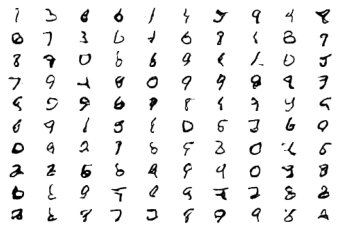

Epoch 81: batch 1/234, d_loss=0.686, g_loss=0.696
Epoch 81: batch 117/234, d_loss=0.691, g_loss=0.699
Epoch 81: batch 234/234, d_loss=0.692, g_loss=0.697
Epoch 82: batch 1/234, d_loss=0.685, g_loss=0.694
Epoch 82: batch 117/234, d_loss=0.688, g_loss=0.697
Epoch 82: batch 234/234, d_loss=0.679, g_loss=0.717
Epoch 83: batch 1/234, d_loss=0.694, g_loss=0.707
Epoch 83: batch 117/234, d_loss=0.690, g_loss=0.702
Epoch 83: batch 234/234, d_loss=0.684, g_loss=0.717
Epoch 84: batch 1/234, d_loss=0.696, g_loss=0.721
Epoch 84: batch 117/234, d_loss=0.692, g_loss=0.700
Epoch 84: batch 234/234, d_loss=0.692, g_loss=0.698
Epoch 85: batch 1/234, d_loss=0.702, g_loss=0.706
Epoch 85: batch 117/234, d_loss=0.693, g_loss=0.714
Epoch 85: batch 234/234, d_loss=0.686, g_loss=0.690
Epoch 86: batch 1/234, d_loss=0.689, g_loss=0.702
Epoch 86: batch 117/234, d_loss=0.692, g_loss=0.714
Epoch 86: batch 234/234, d_loss=0.696, g_loss=0.697
Epoch 87: batch 1/234, d_loss=0.695, g_loss=0.696
Epoch 87: batch 117/234, d

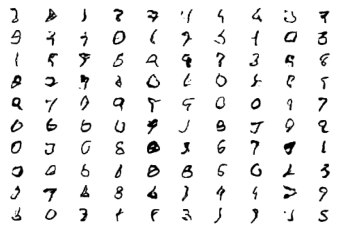

Epoch 91: batch 1/234, d_loss=0.700, g_loss=0.721
Epoch 91: batch 117/234, d_loss=0.695, g_loss=0.718
Epoch 91: batch 234/234, d_loss=0.694, g_loss=0.708
Epoch 92: batch 1/234, d_loss=0.691, g_loss=0.712
Epoch 92: batch 117/234, d_loss=0.692, g_loss=0.694
Epoch 92: batch 234/234, d_loss=0.691, g_loss=0.706
Epoch 93: batch 1/234, d_loss=0.691, g_loss=0.705
Epoch 93: batch 117/234, d_loss=0.697, g_loss=0.719
Epoch 93: batch 234/234, d_loss=0.695, g_loss=0.682
Epoch 94: batch 1/234, d_loss=0.695, g_loss=0.693
Epoch 94: batch 117/234, d_loss=0.695, g_loss=0.702
Epoch 94: batch 234/234, d_loss=0.681, g_loss=0.689
Epoch 95: batch 1/234, d_loss=0.691, g_loss=0.687
Epoch 95: batch 117/234, d_loss=0.691, g_loss=0.707
Epoch 95: batch 234/234, d_loss=0.694, g_loss=0.711
Epoch 96: batch 1/234, d_loss=0.695, g_loss=0.698
Epoch 96: batch 117/234, d_loss=0.683, g_loss=0.710
Epoch 96: batch 234/234, d_loss=0.688, g_loss=0.701
Epoch 97: batch 1/234, d_loss=0.694, g_loss=0.696
Epoch 97: batch 117/234, d

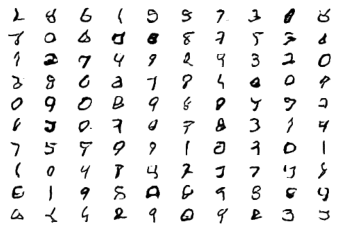

In [ ]:
train_gan(generator, discriminator, gan_model, dataset, latent_dim)